# JAX-MORPH: Gradients and Optimization

The advantage of writing simulation in JAX is that we can easily compute gradients of the simulation with respect to the parameters. This can be used both to carry out sensitivity analysis and to optimize the parameters of the simulation with respect to some objective function.

In this notebook we will show how to use JAX-MORPH to compute gradients of simulations and carry out gradient-based optimization in this setting.

# Imports & Utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np
jax.config.update("jax_enable_x64", True)

key = jax.random.PRNGKey(0)

import jax_morph as jxm
import equinox as eqx
import jax_md


import matplotlib.pyplot as plt

## Animation functions

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def animate_traj_ctype(trajectory, xlim=(-25, 25), ylim=(-25, 25)):

    sim_steps = trajectory.position.shape[0]

    def animate(i):

        ax.clear()  # Clear the axis to remove the previous frame
        ax.set_aspect('equal', 'box')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks([])
        ax.set_yticks([])

        
        state = jxm.BaseCellState(None,
                                  None,
                                  trajectory.position[i],
                                  trajectory.celltype[i],
                                  trajectory.radius[i],
                                  )

        jxm.visualization.draw_circles_ctype(state, ax=ax)

    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    anim = FuncAnimation(fig, animate, frames=sim_steps, interval=100)

    html_anim = HTML(anim.to_jshtml())

    plt.close()

    return html_anim




def animate_traj_chem(trajectory, chem=0, xlim=(-25, 25), ylim=(-25, 25), colorbar=False):

    sim_steps = trajectory.position.shape[0]

    cm = plt.cm.YlGn


    #we only need the chemical field for the plot
    class PlottingCellState(jxm.BaseCellState):
        chemical: np.ndarray

    def animate(i):

        ax.clear()  # Clear the axis to remove the previous frame
        ax.set_aspect('equal', 'box')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks([])
        ax.set_yticks([])

        state = PlottingCellState(None,
                            None,
                            trajectory.position[i],
                            trajectory.celltype[i],
                            trajectory.radius[i],
                            trajectory.chemical[i]
                            )
        

        jxm.visualization.draw_circles_chem(state, chem, colorbar=False, cm=cm, ax=ax)

    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    if colorbar:
        vmax = np.max(trajectory.chemical)

        sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=0, vmax=vmax))
        sm._A = []

        cbar = fig.colorbar(sm, ax=ax, fraction=.05, alpha=.5) # rule of thumb
        cbar.set_label('Conc. Chem. '+str(chem), labelpad=20)


    anim = FuncAnimation(fig, animate, frames=sim_steps, interval=100)

    html_anim = HTML(anim.to_jshtml())

    plt.close()

    return html_anim

# Gradients

## Deterministic Simulations

We define a simple simulation, following the same structure as in notebook 1. Cells move with brownian motion while growing and interacting mechanically via a Morse potential.

Suppose we want to calculate the gradient of a function of the final output of a simulation (e.g. the average cell distance to the center of mass of the whole cluster) with respect to the parameters of the simulation (e.g. the cell-cell adhesion strength).

JAX-MORPH is thought to take advantage of the features of the `Equinox` library for easy computation of gradients.

In [4]:
### CREATE INITIAL STATE


N_CELLS = 10


### INITIALIZE FIELD VALUES

displacement_fn, shift_fn = jax_md.space.free()

key, pos_subkey, rad_subkey = jax.random.split(key, 3)
pos = jax.random.uniform(pos_subkey, (N_CELLS, 2), minval=-5.0, maxval=5.0)
ctype = np.ones((N_CELLS,1))
rad = jax.nn.relu(jax.random.normal(shape=(N_CELLS, 1), key=rad_subkey)*.1 + .3)


istate = jxm.BaseCellState(displacement=displacement_fn, shift=shift_fn, position=pos, celltype=ctype, radius=rad)

print(istate)

BaseCellState(
  displacement=<function displacement_fn>,
  shift=<function shift_fn>,
  position=f64[10,2],
  celltype=f64[10,1],
  radius=f64[10,1]
)


Custom Loss function definition:

In [5]:
def avg_dist_loss(model, istate, run_key, n_steps):

    fstate = jxm.simulate(model, istate, key=run_key, n_steps=n_steps)

    #avg cell distance from center of cluster
    center = np.mean(fstate.position, axis=0)
    avg_dist = np.linalg.norm(fstate.position - center, axis=1).mean()

    return avg_dist

### Defining differentiable parameters

The default setting is that all of the parameters declared as `jax.numpy` arrays are considered as trainable parameters and their gradients are computed. All other parameters are considered as fixed and their gradients are not computed.

By changing the data type of the parameters, we can control which parameters are considered as trainable and which are not. This behavior is guaranteed to work as long as we use Equinox's filtered transformations to compute the gradients (e.g. `eqx.filter_grad`).

In [6]:
### DEFINE SIMULATION STEP


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=np.asarray(3.), alpha=np.asarray(3.), r_cutoff=20., r_onset=15.)


model = jxm.Sequential([

    #cell radius grows linearly in time
    jxm.env.CellGrowth(growth_rate=.005, max_radius=2., growth_type='linear'),

    #cells move with brownian dynamics for 100 steps after each growth step
    jxm.env.mechanics.BrownianMechanicalRelaxation(mech_potential, relaxation_steps=10, kT=1., dt=1e-4)
])

In [7]:
key, subkey = jax.random.split(key)

g = eqx.filter_grad(avg_dist_loss)(model, istate, subkey, 100)

print(g)

Sequential(
  substeps=(
    CellGrowth(
      max_radius=None,
      growth_rate=None,
      growth_type='linear',
      _smoothing_exp=10.0
    ),
    BrownianMechanicalRelaxation(
      mechanical_potential=MorsePotential(
        epsilon=f64[],
        alpha=f64[],
        r_cutoff=20.0,
        r_onset=15.0
      ),
      relaxation_steps=10,
      dt=0.0001,
      kT=1.0,
      gamma=0.8,
      discount=1.0
    )
  ),
  _return_logp=False
)


In [8]:
print(f'Gradient for epsilon:\t{g.substeps[1].mechanical_potential.epsilon}')
print(f'Gradient for aplha:\t{g.substeps[1].mechanical_potential.alpha}')

Gradient for epsilon:	-0.013515793926884779
Gradient for aplha:	0.02199258814469696


If we want instead to calculate gradients with respect to the cell max radius while keeping the cell-cell adhesion strength fixed we just need to change the data type of the appropriate parameters:

In [9]:
### DEFINE SIMULATION STEP


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=3., r_cutoff=20., r_onset=15.)


model = jxm.Sequential([

    #cell radius grows linearly in time
    jxm.env.CellGrowth(growth_rate=.005, max_radius=np.asarray(2.), growth_type='linear'),

    #cells move with brownian dynamics for 100 steps after each growth step
    jxm.env.mechanics.BrownianMechanicalRelaxation(mech_potential, relaxation_steps=10, kT=1., dt=1e-4)
])

In [10]:
key, subkey = jax.random.split(key)

g = eqx.filter_grad(avg_dist_loss)(model, istate, subkey, 100)

print(g)

Sequential(
  substeps=(
    CellGrowth(
      max_radius=f64[],
      growth_rate=None,
      growth_type='linear',
      _smoothing_exp=10.0
    ),
    BrownianMechanicalRelaxation(
      mechanical_potential=MorsePotential(
        epsilon=None,
        alpha=None,
        r_cutoff=20.0,
        r_onset=15.0
      ),
      relaxation_steps=10,
      dt=0.0001,
      kT=1.0,
      gamma=0.8,
      discount=1.0
    )
  ),
  _return_logp=False
)


In [11]:
print(f'Gradient for max_radius:\t{g.substeps[0].max_radius}')

Gradient for max_radius:	-0.0005279311107829494


## Stochastic Simulations

In this case the simulation contains at least one stochastic (non-differentiable) step, e.g. cell division. The 

# Optimization

Once we have the gradients of the simulation with respect to the chosen parameters, we can use them to optimize the parameters with respect to our objective function using a gradient-based optimization algorithm.

Gradients calculated with respect to JAX-morph operations are compatible for use with any standard gradient-based optimizer in JAX or `optax`.

In [12]:
import optax
from tqdm import trange

## Deterministic Simulations

Suppose we only want to optimize the $\epsilon$ parameter of the Morse potential to minimize the average distance of the cells to the center of mass of the cluster:

In [65]:
### DEFINE SIMULATION STEP


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=np.asarray(3.), alpha=np.asarray(3.), r_cutoff=50., r_onset=25.)


model = jxm.Sequential([

    #cell radius grows linearly in time
    jxm.env.CellGrowth(growth_rate=.005, max_radius=2., growth_type='linear'),

    #cells move with brownian dynamics for 100 steps after each growth step
    jxm.env.mechanics.BrownianMechanicalRelaxation(mech_potential, relaxation_steps=10, kT=1., dt=1e-4)
])

### Training loop (SGD)

In order to take full advantage of `Equinox`'s capabilities, we need to split the model into the static and the differentiable parts before feeding the differentiable part to the optimizer. We do this by using `eqx.filter` to separate the jax.array parameters from the rest of the model.

We also need to use `eqx.apply_updates` to apply the updates to the model instead of `optax.apply_updates` to ensure that the updates are only applied to the differentiable part of the model.

Apart from these two small changes, everything runs pretty much as usual.

**NOTE:** In this simple implementation we are only running one single simulation per optimization step. We show below how to batch gradients calculations to reduce noise in the gradients.

In [95]:
N_SIM_STEPS = 100 #length of each forward simulation
EPOCHS = 1500


#function that computes the loss and gradient
loss_and_grad = eqx.filter_jit(eqx.filter_value_and_grad(avg_dist_loss))

#create copy of the model to be modified during traning
opt_model = model.copy()


#initialize optimizer
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(eqx.filter(opt_model, eqx.is_array)) #initialize state


losses = []

for epoch in trange(EPOCHS):

    key, subkey = jax.random.split(key)

    #compute gradient and loss
    loss, grad = loss_and_grad(opt_model, istate, subkey, N_SIM_STEPS)

    #update parameters
    updates, opt_state = optimizer.update(grad, opt_state)

    opt_model = eqx.apply_updates(opt_model, updates)

    losses += [loss]
        

100%|██████████| 1500/1500 [00:19<00:00, 78.32it/s]


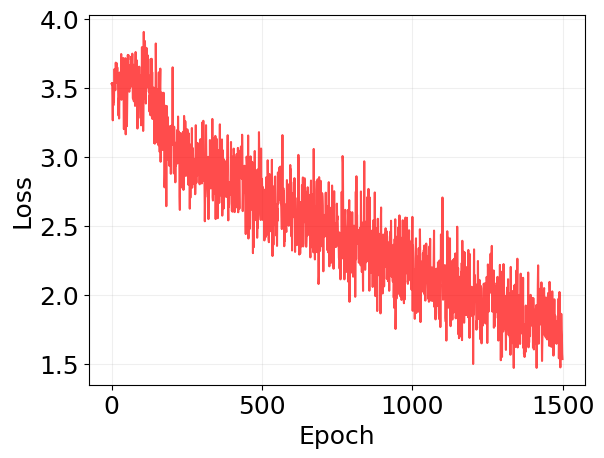

In [96]:
plt.plot(losses, 'r', alpha=.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.2)

plt.show()


In [97]:
print('INITIAL PARAMETERS\n--------------------')
print(f'Initial epsilon:\t{model.substeps[1].mechanical_potential.epsilon}')
print(f'Initial alpha:\t\t{model.substeps[1].mechanical_potential.alpha}')

print('\n')

print('OPTIMIZED PARAMETERS\n-------------------')
print(f'Optimized epsilon:\t{opt_model.substeps[1].mechanical_potential.epsilon}')
print(f'Optimized alpha:\t{opt_model.substeps[1].mechanical_potential.alpha}')

INITIAL PARAMETERS
--------------------
Initial epsilon:	3.0
Initial alpha:		3.0


OPTIMIZED PARAMETERS
-------------------
Optimized epsilon:	20.51911715882836
Optimized alpha:	0.44935480944358375


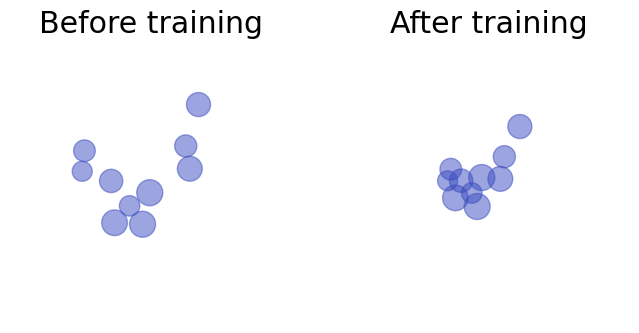

In [99]:
#figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


fstate = jxm.simulate(model, istate, key=key, n_steps=N_SIM_STEPS)
jxm.visualization.draw_circles_ctype(fstate, ax=axs[0])
axs[0].set_title('Before training')
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(-10, 10)


fstate = jxm.simulate(opt_model, istate, key=key, n_steps=N_SIM_STEPS)
jxm.visualization.draw_circles_ctype(fstate, ax=axs[1])
axs[1].set_title('After training')
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-10, 10)

plt.show()


### Training loop (mini-batch SGD)

We now average multiple gradient evaluations per step, reducing the noise in the gradients.

In [104]:
N_SIM_STEPS = 100 #length of each forward simulation
EPOCHS = 1500
BATCH_SIZE = 8

#calculate average loss over a batch of simulations
v_loss = lambda m, s, skeys, steps: jax.vmap(avg_dist_loss, in_axes=(None, None, 0, None))(m, s, skeys, steps).mean()

#function that computes the loss and gradient
loss_and_grad = eqx.filter_jit(eqx.filter_value_and_grad(v_loss))


#create copy of the model to be modified during traning
opt_model = model.copy()

#initialize optimizer
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(eqx.filter(opt_model, eqx.is_array)) #initialize state


losses = []

for epoch in trange(EPOCHS):

    key, *subkeys = jax.random.split(key, BATCH_SIZE+1)
    subkeys = np.asarray(subkeys)

    #compute gradient and loss
    loss, grad = loss_and_grad(opt_model, istate, subkeys, N_SIM_STEPS)

    #update parameters
    updates, opt_state = optimizer.update(grad, opt_state)

    opt_model = eqx.apply_updates(opt_model, updates)

    losses += [loss]
        

100%|██████████| 500/500 [00:57<00:00,  8.76it/s]


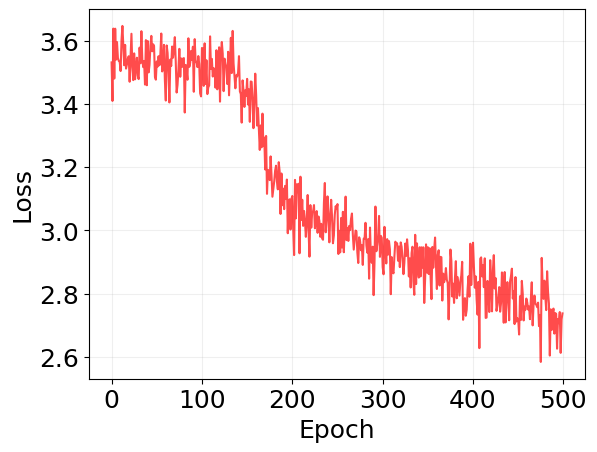

In [105]:
plt.plot(losses, 'r', alpha=.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.2)

plt.show()


In [106]:
print('INITIAL PARAMETERS\n--------------------')
print(f'Initial epsilon:\t{model.substeps[1].mechanical_potential.epsilon}')
print(f'Initial alpha:\t\t{model.substeps[1].mechanical_potential.alpha}')

print('\n')

print('OPTIMIZED PARAMETERS\n-------------------')
print(f'Optimized epsilon:\t{opt_model.substeps[1].mechanical_potential.epsilon}')
print(f'Optimized alpha:\t{opt_model.substeps[1].mechanical_potential.alpha}')

INITIAL PARAMETERS
--------------------
Initial epsilon:	3.0
Initial alpha:		3.0


OPTIMIZED PARAMETERS
-------------------
Optimized epsilon:	9.87279450856032
Optimized alpha:	0.383339993104521


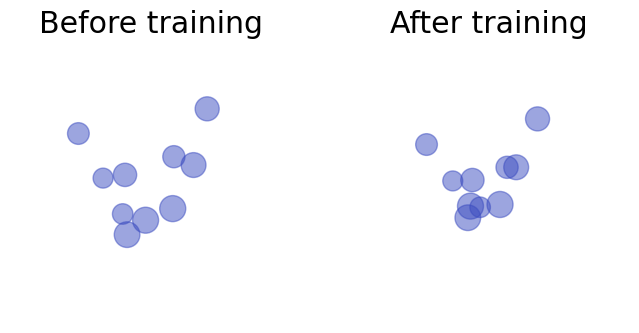

In [107]:
#figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


fstate = jxm.simulate(model, istate, key=key, n_steps=N_SIM_STEPS)
jxm.visualization.draw_circles_ctype(fstate, ax=axs[0])
axs[0].set_title('Before training')
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(-10, 10)


fstate = jxm.simulate(opt_model, istate, key=key, n_steps=N_SIM_STEPS)
jxm.visualization.draw_circles_ctype(fstate, ax=axs[1])
axs[1].set_title('After training')
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-10, 10)

plt.show()
